In [198]:
import numpy as np
import pickle
import neuraltda.SimplicialComplex as sc
import matplotlib.pyplot as plt
%matplotlib inline
reload(sc)

<module 'neuraltda.SimplicialComplex' from '/Users/brad/GentnerLab/code/NeuralTDA/neuraltda/SimplicialComplex.pyc'>

In [10]:
resF = ['/Volumes/gentner/btheilma/experiments/B1075/phy041216/Pen01_Lft_AP300_ML700__Site03_Z2700__B1075_cat_P01_S03_1/20170127T183908Z-10.0-5.0-4.0-TotalTopology.pkl',
        '/Volumes/gentner/btheilma/experiments/B1235/phy051316/Pen02_Lft_AP200_ML800__Site01_Z3000__B1235_cat_P02_S01_1/20170127T235347Z-10.0-5.0-4.0-TotalTopology.pkl',
        '/Volumes/gentner/btheilma/experiments/B1083/klusta/phy040516/Pen03_Lft_AP0_ML1000__Site03_Z2700__B1083_cat_P03_S03_1/20170127T202857Z-10.0-5.0-4.0-TotalTopology.pkl']

resF = ['/Volumes/gentner/btheilma/experiments/B1235/phy051316/Pen02_Lft_AP200_ML800__Site01_Z3000__B1235_cat_P02_S01_1/20170127T235347Z-10.0-5.0-4.0-TotalTopology.pkl',
        '/Volumes/gentner/btheilma/experiments/B1235/phy051316/Pen02_Lft_AP200_ML800__Site03_Z3000__B1235_cat_P02_S03_1/20170128T005306Z-10.0-5.0-4.0-TotalTopology.pkl',
        '/Volumes/gentner/btheilma/experiments/B1235/phy051316/Pen02_Lft_AP200_ML800__Site04_Z3800__B1235_cat_P02_S04_1/20170128T005334Z-10.0-5.0-4.0-TotalTopology.pkl']
for resfname in resF:
    with open(resfname, 'r') as fd:
        resDict = pickle.load(fd)
        print(resDict)
        ec = 0
        for ind, num in enumerate(resDict['raw']['bettis'][1][1:]):
            ec = ec + (-1)**ind * num
        print(ec)
        

{'raw': {'bettis': [11963, [1, 25, 779, 61, 0]]}}
-693
{'raw': {'bettis': [15765, [1, 11, 837, 1472, 0, 0, 0, 0, 0, 0]]}}
646
{'raw': {'bettis': [10170, [1, 34, 623, 113, 0]]}}
-476


In [3]:
resDict

{'raw': {'bettis': [488, [1, 150, 21, 0]]}}

In [12]:
E = dict()
E[3] = 1

In [13]:
E

{3: 1}

In [15]:
E=[[] for ind in range(4)]

In [16]:
E

[[], [], [], []]

In [148]:
def union(a, b):
    return list(set(a) | set(b))

def primaryFaces(Q):
    L = []
    d = len(Q)
    Q = list(Q)
    Q.extend(Q[:d-2])
    for ind in range(d):
        s = (Q[ind:ind+(d-1)])
        L.append(tuple(sorted(s)))
    return L

def simplicialChainGroups(maxsimps):
    maxdim = max([len(s) for s in maxsimps])
    E=[[] for ind in range(maxdim+2)]
    K = list(maxsimps)
    while(len(K) > 0):
        Q = K.pop(0)
        L = primaryFaces(Q)
        k = len(Q)-1
        K = union(K, L)
        E[k] = union(E[k], L)
        E[k+1] = union(E[k+1], {Q})
    for k in range(len(E)):
        E[k] = sorted(E[k])
    return E

def boundaryOperator(Q):
    sgn = 1
    c = dict()
    Ql = list(Q)
    for ind in range(len(Ql)):
        n = Ql.pop(ind)
        c[tuple(Ql)] = sgn
        Ql.insert(ind, n)
        sgn = -1*sgn
    return c

def canonicalCoordinates(c, K):
    v = np.zeros(len(K))
    for ind in range(len(K)):
        if c.has_key(K[ind]):
            v[ind] = c[K[ind]]
    return v

def boundaryOperatorMatrix(E):
    
    nmat = len(E)
    D = [[] for i in range(nmat)]
    for k in range(1, nmat):
        m = len(E[k-1])
        n = len(E[k])
        mat = np.zeros((m, n))
        for j in range(n):
            c = boundaryOperator(E[k][j])
            mat[:, j] = canonicalCoordinates(c, E[k-1])
            D[k-1] = mat
    return D

def laplacian(D, dim):
    
    Di = D[dim]
    Di1 = D[dim+1]
    return np.dot(Di.T, Di) + np.dot(Di1, Di1.T)

def expandBasis(mat, oldK, newK, oldKm1, newKm1):
    
    basSource = sorted(union(oldK, newK))
    basTarget = sorted(union(oldKm1, newKm1))
    for ind, b in enumerate(basSource):
        if b not in oldK:
            mat = np.insert(mat, ind, 0, axis=1)
    for ind, b in enumerate(basTarget):
        if b not in oldKm1:
            mat = np.insert(mat, ind, 0, axis=0)
    return mat

In [132]:
mat = np.array([[1,2],[3,4],[5,6]])
oldK = [(1,2), (2,3)]
oldKm1 = [(1,), (2,), (3,)]
newK = [(1,2), (2,3), (6, 7), (8,9)]
newKm1 = [(1,), (2,), (3,), (6,), (7,), (8,), (9,)]
expandBasis(mat, oldK, newK, oldKm1, newKm1)


array([[1, 2, 0, 0],
       [3, 4, 0, 0],
       [5, 6, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [134]:
E = simplicialChainGroups(sorted([(1,2), (3,4), (4,5), (1,4), (2,5)]), 1)
D = boundaryOperatorMatrix(E)
print(E)
print(D)

[[()], [(1,), (2,), (3,), (4,), (5,)], [(1, 2), (1, 4), (2, 5), (3, 4), (4, 5)]]
[array([[ 1.,  1.,  1.,  1.,  1.]]), array([[-1., -1.,  0.,  0.,  0.],
       [ 1.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  1., -1.],
       [ 0.,  0.,  1.,  0.,  1.]]), []]


In [177]:
n = np.random.rand(30, 120)
n = (n > 0.90).astype(int)
maxSimpList = sorted(sc.BinaryToMaxSimplex(n, rDup=True))
maxSimpList


[(0,),
 (0, 1),
 (0, 1, 11, 18, 24, 26),
 (0, 2, 4, 8, 10, 17, 29),
 (0, 2, 9, 14, 18),
 (0, 2, 11, 17, 19, 21, 23),
 (0, 3),
 (0, 4),
 (0, 4, 7),
 (0, 4, 21, 24),
 (0, 5, 11, 15, 27, 28),
 (0, 7, 25, 28, 29),
 (0, 8, 11, 18, 26),
 (0, 15, 24),
 (0, 20, 24),
 (1,),
 (1, 2, 11, 20, 25),
 (1, 4, 7, 11, 17, 24),
 (1, 8, 28, 29),
 (1, 10, 24),
 (1, 11, 21, 28),
 (1, 17, 23),
 (1, 22, 26, 29),
 (2, 4, 6, 13),
 (2, 12, 16, 21, 26),
 (2, 18),
 (2, 19),
 (3, 4, 10, 21),
 (3, 5, 19, 23),
 (3, 5, 28),
 (3, 10, 18, 23, 29),
 (3, 16, 17),
 (3, 18, 21, 22),
 (3, 25),
 (4, 6, 7, 21, 23),
 (4, 6, 9),
 (4, 6, 13, 14, 27),
 (4, 6, 13, 27),
 (4, 8, 12, 13, 20),
 (4, 16),
 (5,),
 (5, 9, 29),
 (5, 11, 14, 21, 23, 27),
 (5, 13, 27),
 (5, 15, 19, 29),
 (5, 22),
 (5, 27),
 (6, 8),
 (6, 9),
 (6, 10, 16, 18, 19, 26),
 (6, 14, 22),
 (6, 18, 29),
 (6, 23, 29),
 (6, 28, 29),
 (7, 9, 17, 23),
 (7, 11, 23),
 (7, 14, 16, 19, 20, 24),
 (7, 16, 22, 28, 29),
 (7, 24, 28, 29),
 (7, 25),
 (8, 11),
 (8, 13, 27, 28),
 (8, 

In [178]:
E = simplicialChainGroups(maxSimpList)
E

[[()],
 [(0,),
  (1,),
  (2,),
  (3,),
  (4,),
  (5,),
  (6,),
  (7,),
  (8,),
  (9,),
  (10,),
  (11,),
  (12,),
  (13,),
  (14,),
  (15,),
  (16,),
  (17,),
  (18,),
  (19,),
  (20,),
  (21,),
  (22,),
  (23,),
  (24,),
  (25,),
  (26,),
  (27,),
  (28,),
  (29,)],
 [(0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 7),
  (0, 8),
  (0, 9),
  (0, 10),
  (0, 11),
  (0, 14),
  (0, 15),
  (0, 17),
  (0, 18),
  (0, 19),
  (0, 20),
  (0, 21),
  (0, 23),
  (0, 24),
  (0, 25),
  (0, 26),
  (0, 27),
  (0, 28),
  (0, 29),
  (1, 2),
  (1, 4),
  (1, 7),
  (1, 8),
  (1, 10),
  (1, 11),
  (1, 17),
  (1, 18),
  (1, 20),
  (1, 21),
  (1, 22),
  (1, 23),
  (1, 24),
  (1, 25),
  (1, 26),
  (1, 28),
  (1, 29),
  (2, 4),
  (2, 6),
  (2, 8),
  (2, 9),
  (2, 10),
  (2, 11),
  (2, 12),
  (2, 13),
  (2, 14),
  (2, 16),
  (2, 17),
  (2, 18),
  (2, 19),
  (2, 20),
  (2, 21),
  (2, 23),
  (2, 25),
  (2, 26),
  (2, 29),
  (3, 4),
  (3, 5),
  (3, 10),
  (3, 16),
  (3, 17),
  (3, 18),
  (3, 19),
  (3, 21),
  

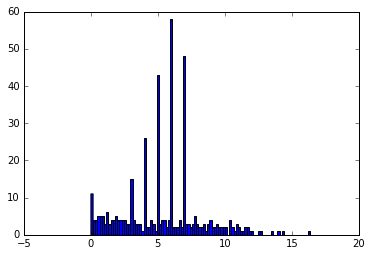

In [202]:
D = boundaryOperatorMatrix(E)
w, v = np.linalg.eig(laplacian(D, 2))
plt.hist(np.real(w), 100)
plt.show()

In [102]:
c = boundaryOperator((1,2,3))
E = [(1,2), (1,3), (2,3), (4,5)]
canonicalCoordinates(c, E)

array([ 1., -1.,  1.,  0.])

In [52]:
set([1,2])

{1, 2}

In [55]:
set([]).union(*[[1,2], [2,3]])

{1, 2, 3}

In [57]:
tuple([[1,2],[3,4]])

([1, 2], [3, 4])

In [122]:
np.outer([-4, -2, 3], [1,3,1])

array([[ -4, -12,  -4],
       [ -2,  -6,  -2],
       [  3,   9,   3]])